In [ ]:
!git clone https://github.com/dayeonki/askqe

fatal: destination path 'askqe' already exists and is not an empty directory.


In [ ]:
import sys
REPO_PATH = "askqe"

sys.path.insert(0, REPO_PATH)
sys.path.insert(0, f"{REPO_PATH}/QG/code")
sys.path.insert(0, f"{REPO_PATH}/QA/code")
sys.path.insert(0, f"{REPO_PATH}/biomqm/askqe")
sys.path.insert(0, f"{REPO_PATH}/evaluation/string-comparison")

In [ ]:
import os
os.environ["VLLM_WORKER_MULTIPROC_METHOD"] = "spawn"

In [ ]:
!pip install -q vllm
!pip install sacrebleu

In [ ]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


#Loading data

In [ ]:
from QG.code.prompt import nli as qg_prompt_template
from QA.code.prompt import qa_prompt as qa_prompt_template
from biomqm.askqe.prompt import atomic_fact_prompt as atomic_fact_prompt_template

In [ ]:
import json
import os
import glob

LIMIT = None # change to minimize data or None


def calculate_mqm_score(errors):
    weights = {"Minor": 1, "Major": 5, "Critical": 25}
    score_penalty = 0
    for error in errors:
        severity = error.get("severity")
        score_penalty += weights.get(severity, 0)
    return max(0, 100 - score_penalty)

def get_max_severity(errors):
    if not errors:
        return "No Error"
    severities = [e.get("severity") for e in errors]
    if "Critical" in severities:
        return "Critical"
    if "Major" in severities:
        return "Major"
    return "Minor"

def load_biomqm_data(file_path, limit=None):
    data_entries = []
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            for i, line in enumerate(f):
                if limit and i >= limit:
                    break
                item = json.loads(line)

                # BIOMQM structure: src, tgt, bt_tgt, errors_tgt
                entry = {
                    'id': item.get('doc_id', f'doc_{i}'),
                    'source': item['src'],
                    'target': item['tgt'],
                    'backtranslation': item.get('bt_tgt', ''),
                    'errors': item.get('errors_tgt', []),
                    'mqm_score': calculate_mqm_score(item.get('errors_tgt', [])),
                    'severity': get_max_severity(item.get('errors_tgt', []))
                }
                data_entries.append(entry)

        print(f"Loaded {len(data_entries)} entries from BIOMQM successfully.")
        return data_entries
    except FileNotFoundError:
        print(f"Error: File {file_path} not found.")
        return []


BIOMQM_FILE = f"{REPO_PATH}/biomqm/dev_with_backtranslation.jsonl"
dataset = load_biomqm_data(BIOMQM_FILE, limit=LIMIT)


Loaded 5216 entries from BIOMQM successfully.


#Cleaning data

In [ ]:
import pandas as pd

def term_in_data(df):
    valid_rows = []

    for row in df:
        tgt = row.get('target', '')
        src = row.get('source', '')
        errors = row.get('errors', [])
        is_row_clean = True

        for error in errors:
            term = error.get('term', '')

            if term:
                if term not in tgt and term not in src:
                    is_row_clean = False
                    break

        if is_row_clean:
            valid_rows.append(row)

    return valid_rows

dataset_clean = term_in_data(dataset)
print(f"Cleaned data with shape = {len(dataset_clean)}")

Cleaned data with shape = 5000


#Model init

In [ ]:
from vllm import LLM, SamplingParams

MODEL_ID = "Qwen/Qwen2.5-3B-Instruct-AWQ"

# QWEN
#"Qwen/Qwen2.5-3B-Instruct-AWQ"
#"Qwen/Qwen2.5-7B-Instruct-AWQ"
#"Qwen/Qwen2.5-14B-Instruct-AWQ"
#"Qwen/Qwen3-4B-Instruct-2507"
#"cyankiwi/Qwen3-30B-A3B-Instruct-2507-AWQ-4bit"
#Qwen/Qwen3-4B-Instruct-2507


# Llama
#"meta-llama/Meta-Llama-3-8B-Instruct"

# Gemma
#"casperhansen/gemma-7b-it-awq"
#"google/gemma-2-9b-it"
#"solidrust/gemma-2-9b-it-AWQ"

# Yi
#"01-ai/Yi-1.5-9B"
#"01-ai/Yi-1.5-6B"

# Mistral
#casperhansen/mistral-nemo-instruct-2407-awq

llm = LLM(
    model=MODEL_ID,
    dtype="half",
    max_model_len=2048,
    gpu_memory_utilization=0.60,
    quantization="awq_marlin",
    seed=0,
    enable_prefix_caching=True,
    disable_log_stats=True,
    # enforce_eager=False,
)

INFO 12-30 20:34:10 [utils.py:253] non-default args: {'dtype': 'half', 'max_model_len': 2048, 'enable_prefix_caching': True, 'gpu_memory_utilization': 0.6, 'disable_log_stats': True, 'quantization': 'awq', 'model': 'Qwen/Qwen2.5-3B-Instruct-AWQ'}
INFO 12-30 20:34:12 [model.py:514] Resolved architecture: Qwen2ForCausalLM
INFO 12-30 20:34:12 [model.py:1661] Using max model len 2048
INFO 12-30 20:34:12 [awq_marlin.py:166] Detected that the model can run with awq_marlin, however you specified quantization=awq explicitly, so forcing awq. Use quantization=awq_marlin for faster inference
INFO 12-30 20:34:16 [scheduler.py:230] Chunked prefill is enabled with max_num_batched_tokens=8192.
INFO 12-30 20:35:11 [llm.py:360] Supported tasks: ['generate']


In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_ID, trust_remote_code=True)

SAMPLING_PARAMS = SamplingParams(
    temperature=0,
    max_tokens=1024
)


def generate_text_batch(prompts, sampling_params=SAMPLING_PARAMS):
    formatted_prompts = []
    for p in prompts:
        messages = [{"role": "user", "content": p}]
        formatted = tokenizer.apply_chat_template(
            messages,
            tokenize=False,
            add_generation_prompt=True
        )
        formatted_prompts.append(formatted)

    outputs = llm.generate(formatted_prompts, sampling_params)

    generated_texts = []
    for output in outputs:
        text = output.outputs[0].text.strip()
        if not text.endswith("]"):
            text = text + "]"
        if not text.startswith("["):
            text = "[" + text
        generated_texts.append(text)

    return generated_texts

def parse_list_output(text):
    """Parses a string representation of a list into a Python list."""
    import ast
    try:
        start = text.find('[')
        end = text.rfind(']') + 1
        if start != -1 and end != -1:
            candidate = text[start:end]
            return ast.literal_eval(candidate)
        return []
    except:
        return []


#AskQE pipeline

In [ ]:
from transformers import pipeline
import numpy as np

N = len(dataset)

all_facts = [[] for _ in range(N)]
all_questions = [[] for _ in range(N)]
all_answers_src = [[] for _ in range(N)]
all_answers_bt = [[] for _ in range(N)]

print(f"Using cleaned data with shape = {len(dataset_clean)}")

# =============================================================================
# PHASE 1: Atomic Fact Extraction
# =============================================================================
print("\n" + "=" * 60)
print("PHASE 1: Atomic Fact Extraction")
print("=" * 60)

prompts_facts = [
    atomic_fact_prompt_template.replace("{{sentence}}", e["source"])
    for e in dataset_clean
]

facts_str_list = generate_text_batch(prompts_facts, SAMPLING_PARAMS)
raw_all_facts = [parse_list_output(s) for s in facts_str_list]
print(f"Facts extracted: {sum(len(f) for f in raw_all_facts)} total facts")
num_empty = raw_all_facts.count([])
print(f"Number of empty fact lists: {num_empty}")

# =============================================================================
# PHASE 1.5: Entailment Filtering
# =============================================================================
print("\n" + "=" * 60)
print("PHASE 1.5: NLI Entailment Filtering")
print("=" * 60)

NLI_MODEL_ID = "potsawee/deberta-v3-large-mnli"

nli_pipeline = pipeline(
    "text-classification",
    model=NLI_MODEL_ID,
    device=device
)

flat_nli_inputs = []
for idx, facts in enumerate(raw_all_facts):
    if not facts:
        continue
    source = dataset_clean[idx]["source"]
    for fact in facts:
        flat_nli_inputs.append((idx, fact, [source, fact]))

print(f"Running NLI on {len(flat_nli_inputs)} fact-source pairs...")
nli_pairs = [{"text": t[2][0], "text_pair": t[2][1]} for t in flat_nli_inputs]
nli_results = nli_pipeline(nli_pairs, batch_size=64, truncation=True, max_length=512)

kept = 0
for (idx, fact, sfp), res in zip(flat_nli_inputs, nli_results):
    label = res["label"].upper()
    score = res["score"]
    if ("LABEL_1" not in label) or ("LABEL_1" in label and score < 0.85):
        all_facts[idx].append(fact)
        kept += 1

removed = sum(len(f) for f in raw_all_facts) - kept
print(f"NLI Complete: {kept} facts retained (filtered {removed} contradictions)")
num_empty = all_facts.count([])
print(f"Number of empty fact lists: {num_empty}")

# =============================================================================
# PHASE 2: Question Generation
# =============================================================================
print("\n" + "=" * 60)
print("PHASE 2: Question Generation")
print("=" * 60)

jobs = []
for idx, facts in enumerate(all_facts):
    if facts:
        prompt = qg_prompt_template.replace("{{sentence}}", dataset_clean[idx]["source"]).replace("{{atomic_facts}}", str(facts))
        jobs.append({"idx": idx, "prompt": prompt})

prompts = [j["prompt"] for j in jobs]
results = generate_text_batch(prompts, SAMPLING_PARAMS)

for job, result in zip(jobs, results):
    all_questions[job["idx"]] = parse_list_output(result)

print(f"Questions generated: {sum(len(q) for q in all_questions)} total")
print(f"Number of empty question lists: {all_questions.count([])}")

# =============================================================================
# PHASE 3 & 4: QA on Source & Backtranslation
# =============================================================================
print("\n" + "=" * 60)
print("PHASE 3 & 4: Question Answering (src + BT)")
print("=" * 60)

prompts_qa_src = []
prompts_qa_bt = []
qa_idx_map = []

for idx, questions in enumerate(all_questions):
    if not questions:
        continue

    # scr prompt
    p_src = (
        qa_prompt_template
        .replace("{{sentence}}", dataset_clean[idx]["source"])
        .replace("{{questions}}", str(questions))
    )
    prompts_qa_src.append(p_src)

    # BT prompt
    p_bt = (
        qa_prompt_template
        .replace("{{sentence}}", dataset_clean[idx].get("backtranslation", ""))
        .replace("{{questions}}", str(questions))
    )
    prompts_qa_bt.append(p_bt)

    qa_idx_map.append(idx)

combined_prompts = prompts_qa_src + prompts_qa_bt
all_answers = generate_text_batch(combined_prompts, SAMPLING_PARAMS)

split_idx = len(prompts_qa_src)
answers_src = all_answers[:split_idx]
answers_bt = all_answers[split_idx:]

for prompt_pos, dataset_idx in enumerate(qa_idx_map):
    curr_questions = all_questions[dataset_idx]

    src_ans = parse_list_output(answers_src[prompt_pos])
    bt_ans = parse_list_output(answers_bt[prompt_pos])

    if len(src_ans) != len(curr_questions) or len(bt_ans) != len(curr_questions):
        src_ans = []
        bt_ans = []

    src_ans = src_ans[:len(curr_questions)]
    bt_ans = bt_ans[:len(curr_questions)]

    all_answers_src[dataset_idx] = src_ans
    all_answers_bt[dataset_idx] = bt_ans

print(f"QA Complete: {sum(len(a) for a in all_answers_src)} source answers, "
      f"{sum(len(a) for a in all_answers_bt)} BT answers")
print(f"Number of empty answers lists (SRC): {all_answers_src.count([])}")
print(f"Number of empty answers lists (BT): {all_answers_bt.count([])}")

# =============================================================================
# FINAL: Build Results List
# =============================================================================
print("\n" + "=" * 60)
print("FINAL: Building Results")
print("=" * 60)

results = []
for idx, entry in enumerate(dataset_clean):
    results.append({
        "id": entry["id"],
        "source": entry["source"],
        "backtranslation": entry.get("backtranslation", ""),
        "facts": all_facts[idx],
        "questions": all_questions[idx],
        "answers_src": all_answers_src[idx],
        "answers_bt": all_answers_bt[idx],
        "mqm_score": entry.get("mqm_score", None),
        "severity": entry.get("severity", None),
    })

print("\nPipeline execution complete.")

output_file = "askqe_data.jsonl"
with open(output_file, 'w') as f:
    for res in results:
        f.write(json.dumps(res) + '\n')

print(f"Results saved to {output_file}")

Using cleaned data with shape = 5000

PHASE 1: Atomic Fact Extraction


Adding requests:   0%|          | 0/5000 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/5000 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s…

Facts extracted: 12219 total facts
Number of empty fact lists: 206

PHASE 1.5: NLI Entailment Filtering


config.json:   0%|          | 0.00/883 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.74G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/400 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.74G [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/23.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/173 [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/convert_slow_tokenizer.py:566: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Device set to use cuda


Running NLI on 12219 fact-source pairs...
NLI Complete: 9538 facts retained (filtered 2681 contradictions)
Number of empty fact lists: 751

PHASE 2: Question Generation


Adding requests:   0%|          | 0/4465 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/4465 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s…

Questions generated: 10456 total
Number of empty question lists: 751

PHASE 3 & 4: Question Answering (src + BT)


Adding requests:   0%|          | 0/8930 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/8930 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s…

QA Complete: 9704 source answers, 9704 BT answers
Number of empty answers lists (SRC): 971
Number of empty answers lists (BT): 971

FINAL: Building Results

Pipeline execution complete.
Results saved to askqe_data.jsonl


#Scoring & Evaluation

In [ ]:
import json
import torch

from utils import (
    f1_score as repo_f1_score,
    exact_match_score as repo_exact_match_score,
    chrf_score as repo_chrf_score,
    bleu_score as repo_bleu_score,
    compare_answers as repo_compare_answers,
    normalize_answer
)

device = "cuda" if torch.cuda.is_available() else "cpu"

output_file = "askqe_data.jsonl"

results = []
lost_cnt = 0
with open(output_file, "r") as f:
    for line in f:
        line = line.strip()
        if not line:
            continue
        data = json.loads(line)
        if data.get("answers_src") and data.get("answers_bt"):
            results.append(data)
        else:
            lost_cnt += 1

print(f"Loaded {len(results) - lost_cnt} out of {len(results)} records from {output_file}")
print("First element example:", results[0] if results else "empty list")

Loaded 3490 out of 4245 records from askqe_data.jsonl
First element example: {'id': 'doc11', 'source': 'Three cases of cervicofacial NF are presented in this case report.', 'backtranslation': 'This case report presents three cases of cervicofacial NF.', 'facts': ['Three cases of cervicofacial NF are presented in this case report.'], 'questions': ['How many cases of cervicofacial NF are presented in this case report?'], 'answers_src': ['Three'], 'answers_bt': ['Three'], 'mqm_score': 95, 'severity': 'Major'}


## ASKQE scores using different metrics evaluated on BIOMQM per error severity

In [ ]:
import numpy as np
from collections import Counter
from sacrebleu import sentence_bleu, sentence_chrf
from sentence_transformers import SentenceTransformer, util
import json

sbert_model = SentenceTransformer('all-MiniLM-L6-v2', device=device)
print("Calculating Scores...")

all_src_answers = []
all_bt_answers = []
indices_map = []

for i, res in enumerate(results):

    src_list = res.get('answers_src', [])
    bt_list = res.get('answers_bt', [])

    if src_list and bt_list:
        src_str_list = [str(x) for x in src_list]
        bt_str_list = [str(x) for x in bt_list]

        all_src_answers.extend(src_str_list)
        all_bt_answers.extend(bt_str_list)

        indices_map.append((i, len(src_list)))

        f1_vals = []
        em_vals = []
        bleu_vals = []
        chrf_vals = []

        for p, g in zip(src_str_list, bt_str_list):
            f1_vals.append(repo_f1_score(p, g, normalize=True))
            em_vals.append(int(repo_exact_match_score(p, g, normalize=True)))
            bleu_vals.append(sentence_bleu(p, [g]).score)
            chrf_vals.append(sentence_chrf(p, [g]).score)

        results[i]['askqe_f1'] = np.mean(f1_vals)
        results[i]['askqe_em'] = np.mean(em_vals)
        results[i]['askqe_bleu'] = np.mean(bleu_vals)
        results[i]['askqe_chrf'] = np.mean(chrf_vals)
    else:
        indices_map.append((i, 0))
        results[i]['askqe_f1'] = 0.0
        results[i]['askqe_em'] = 0.0
        results[i]['askqe_bleu'] = 0.0
        results[i]['askqe_chrf'] = 0.0
        results[i]['askqe_sbert'] = 0.0

print(f"Encoding {len(all_src_answers)} answer pairs simultaneously...")

embeddings_src = sbert_model.encode(all_src_answers, batch_size=64, convert_to_tensor=True)
embeddings_bt = sbert_model.encode(all_bt_answers, batch_size=64, convert_to_tensor=True)

cursor = 0
for idx, count in indices_map:
    if count > 0:
        doc_scores = []
        for k in range(count):
            sim = util.cos_sim(embeddings_src[cursor + k], embeddings_bt[cursor + k]).item()
            doc_scores.append(sim)

        results[idx]['askqe_sbert'] = np.mean(doc_scores)
        cursor += count
    else:
        if 'askqe_sbert' not in results[idx]:
             results[idx]['askqe_sbert'] = 0.0

print("Scoring complete")

output_file = "askqe_results.jsonl"
with open(output_file, 'w') as f:
    for res in results:
        f.write(json.dumps(res) + '\n')

print(f"Results saved to {output_file}")

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Calculating Scores...
Encoding 9704 answer pairs simultaneously...
Scoring complete
Results saved to askqe_results.jsonl


Severity   F1     EM     CHRF   BLEU   SBERT 
No Error   0.751  0.482  79.56   62.45   0.871
Minor      0.733  0.429  77.45   59.71   0.859
Major      0.691  0.393  74.88   57.07   0.838
Critical   0.614  0.369  69.02   49.54   0.747


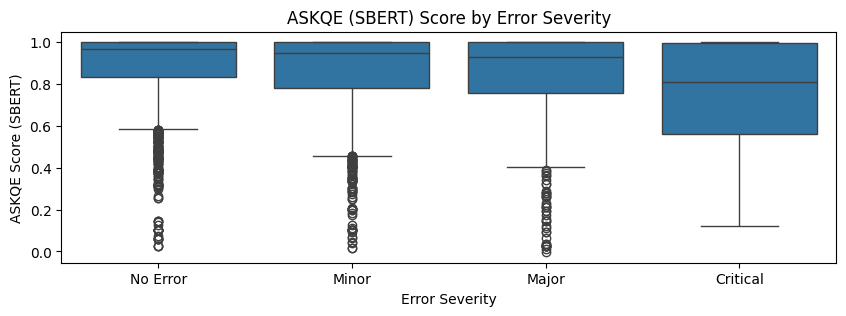

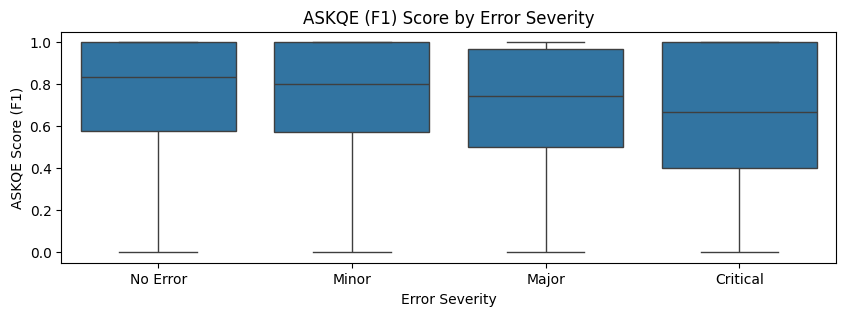

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

categories = ["No Error", "Minor", "Major", "Critical"]
print(f"{'Severity':<10} {'F1':<6} {'EM':<6} {'CHRF':<6} {'BLEU':<6} {'SBERT':<6}")

for cat in categories:

    group = [r for r in results if r.get('severity') == cat]
    if not group:
        continue

    avg_f1    = np.mean([r.get('askqe_f1', 0) for r in group])
    avg_em    = np.mean([r.get('askqe_em', 0) for r in group])
    avg_chrf  = np.mean([r.get('askqe_chrf', 0) for r in group])
    avg_bleu  = np.mean([r.get('askqe_bleu', 0) for r in group])
    avg_sbert = np.mean([r.get('askqe_sbert', 0) for r in group])

    print(f"{cat:<10} {avg_f1:.3f}  {avg_em:.3f}  {avg_chrf:.2f}   {avg_bleu:.2f}   {avg_sbert:.3f}")


# plot
plt.figure(figsize=(10, 3))

order = ["No Error", "Minor", "Major", "Critical"]

sns.boxplot(x='severity', y='askqe_sbert', data=pd.DataFrame(results), order=order)
plt.title('ASKQE (SBERT) Score by Error Severity')
plt.ylabel('ASKQE Score (SBERT)')
plt.xlabel('Error Severity')
plt.show()

plt.figure(figsize=(10, 3))
sns.boxplot(x='severity', y='askqe_f1', data=pd.DataFrame(results), order=order)
plt.title('ASKQE (F1) Score by Error Severity')
plt.ylabel('ASKQE Score (F1)')
plt.xlabel('Error Severity')
plt.show()


###Correlation analysis

In [ ]:
import json

output_file = "askqe_results.jsonl"

results = []
with open(output_file, "r") as f:
    for line in f:
        line = line.strip()
        if not line:
            continue
        results.append(json.loads(line))

print(f"Loaded {len(results)} records from {output_file}")
print("First element example:", results[0] if results else "empty list")

Loaded 4245 records from askqe_results.jsonl
First element example: {'id': 'doc11', 'source': 'Three cases of cervicofacial NF are presented in this case report.', 'backtranslation': 'This case report presents three cases of cervicofacial NF.', 'facts': ['Three cases of cervicofacial NF are presented in this case report.'], 'questions': ['How many cases of cervicofacial NF are presented in this case report?'], 'answers_src': ['Three'], 'answers_bt': ['Three'], 'mqm_score': 95, 'severity': 'Major', 'askqe_f1': 1.0, 'askqe_em': 1.0, 'askqe_bleu': 100.00000000000004, 'askqe_chrf': 100.0, 'askqe_sbert': 1.0}



Correlation Analysis (Kendall's Tau)
Expected: Strong POSITIVE correlation (Higher ASKQE score = Higher MQM score)
Metric     Tau        P-Value   
-----------------------------------
SBERT      0.0647     1.5673e-08
F1         0.0736     3.3975e-10
EM         0.0564     8.9615e-06
BLEU       0.0538     3.7912e-06
CHRF       0.0639     3.7217e-08
-----------------------------------


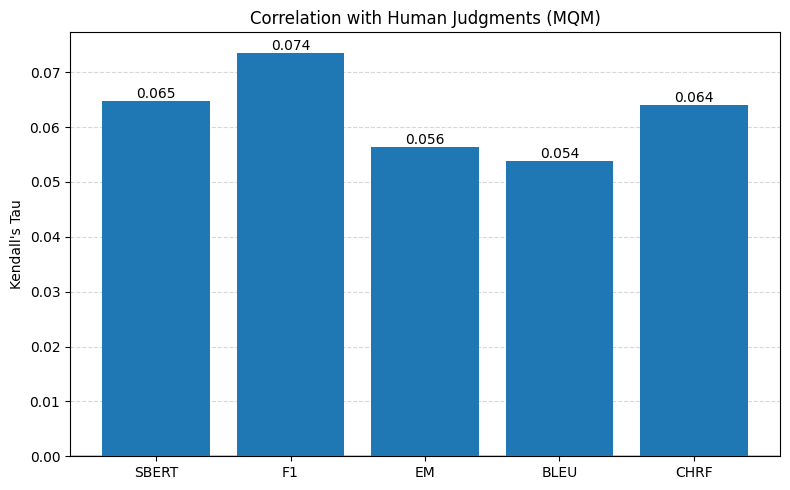

In [ ]:
import scipy.stats
import pandas as pd
import matplotlib.pyplot as plt

df_results = pd.DataFrame(results)

print("\n" + "="*50)
print("Correlation Analysis (Kendall's Tau)")
print("Expected: Strong POSITIVE correlation (Higher ASKQE score = Higher MQM score)")
print("="*50)

metrics = {
    "SBERT": "askqe_sbert",
    "F1":    "askqe_f1",
    "EM":    "askqe_em",
    "BLEU":  "askqe_bleu",
    "CHRF":  "askqe_chrf"
}
names = []
values = []

print(f"{'Metric':<10} {'Tau':<10} {'P-Value':<10}")
print("-" * 35)

for name, col_name in metrics.items():
    tau, p_value = scipy.stats.kendalltau(df_results[col_name], df_results['mqm_score'])
    names.append(name)
    values.append(tau)
    print(f"{name:<10} {tau:.4f}     {p_value:.4e}")

print("-" * 35)

# plot
plt.figure(figsize=(8, 5))
bars = plt.bar(names, values, zorder=3)

plt.grid(axis='y', linestyle='--', alpha=0.5, zorder=0)
plt.axhline(0, color='black', linewidth=1)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, f'{height:.3f}',
             ha='center', va='bottom' if height > 0 else 'top', fontsize=10)

plt.ylabel("Kendall's Tau")
plt.title("Correlation with Human Judgments (MQM)")
plt.tight_layout()
plt.show()


##BT-Score

In [ ]:
def save_checkpoint(data, filename):
    """
    Saves the current state of the 'results' list to disk immediately.
    This overwrites the file with the latest data (including new columns).
    """
    print(f"   [Checkpoint] Saving {len(data)} records to {filename}...")
    with open(filename, 'w', encoding='utf-8') as f:
        for item in data:
            f.write(json.dumps(item, ensure_ascii=False) + '\n')
    print("   [Checkpoint] Done.")

In [ ]:
!pip install -q bert-score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 5.2 MB/s eta 0:00:00


In [ ]:
from bert_score import score as bert_score
import pandas as pd
import scipy.stats

print("Calculating BT-Score...")

_, _, F1 = bert_score(
    [r['backtranslation'] for r in results],
    [r['source'] for r in results],
    lang="en",
    rescale_with_baseline=True,
    verbose=True
)

f1_values = F1.numpy()
for item, score in zip(results, f1_values):
    item['bt_score'] = float(score)

for r in results:
    if 'bt_score' not in r:
        print("WARNING. Some data is missing")
        r['bt_score'] = 0.0

df = pd.DataFrame(results)
tau, p_value = scipy.stats.kendalltau(df['bt_score'], df['mqm_score'])

print("\n" + "="*40)
print(f"{'Metric':<10} {'Tau':<10} {'P-Value':<10}")
print("-" * 40)
print(f"{'BT-Score':<10} {tau:.4f}     {p_value:.4e}")
print("="*40)

save_checkpoint(results, "askqe_results_final.jsonl")

Calculating BT-Score...


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/44 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/67 [00:00<?, ?it/s]

done in 11.10 seconds, 382.40 sentences/sec

Metric     Tau        P-Value   
----------------------------------------
BT-Score   0.1111     7.6305e-23
   [Checkpoint] Saving 4245 records to askqe_results_final.jsonl...
   [Checkpoint] Done.


## xCOMET-QE

In [ ]:
!pip install -q unbabel-comet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.0/91.0 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.4/101.4 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 126.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 31.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.5/849.5 kB 63.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 529.7/529.7 kB 44.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jax 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
ydf 0.13.0 requires protobuf<7.0.0,>=5.29.1, but you have protobuf 4.25.8 which is incompatible.
jaxlib

In [ ]:
from comet import download_model, load_from_checkpoint
import pandas as pd
import scipy.stats

print("Loading xCOMET-QE model...")
model_path = download_model("Unbabel/wmt20-comet-qe-da") # Unbabel/wmt22-cometkiwi-da
model = load_from_checkpoint(model_path)

print("Calculating xCOMET-QE Score...")

comet_data = []
valid_indices = []

for i, r in enumerate(results):
    if r.get('source') and r.get('backtranslation'):
        comet_data.append({
            "src": r['source'],
            "mt": r['backtranslation']
        })
        valid_indices.append(i)
    else:
        print("WARNING. Some data is missing")
        r['xcomet_score'] = 0.0

if comet_data:
    gpus = 1 if torch.cuda.is_available() else 0
    model_output = model.predict(comet_data, batch_size=8, gpus=gpus)
    for idx, score in zip(valid_indices, model_output.scores):
        results[idx]['xcomet_score'] = float(score)

df = pd.DataFrame(results)

tau, p_value = scipy.stats.kendalltau(df['xcomet_score'], df['mqm_score'])

print("\n" + "="*40)
print(f"{'Metric':<10} {'Tau':<10} {'P-Value':<10}")
print("-" * 40)
print(f"{'xCOMET-QE':<10} {tau:.4f}     {p_value:.4e}")
print("="*40)

save_checkpoint(results, "askqe_results_final.jsonl")


/usr/local/lib/python3.12/dist-packages/torchmetrics/utilities/imports.py:23: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loading xCOMET-QE model...


.gitattributes: 0.00B [00:00, ?B/s]

LICENSE: 0.00B [00:00, ?B/s]

README.md: 0.00B [00:00, ?B/s]

checkpoints/model.ckpt:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

hparams.yaml:   0%|          | 0.00/479 [00:00<?, ?B/s]

INFO:pytorch_lightning.utilities.migration.utils:Lightning automatically upgraded your loaded checkpoint from v1.3.5 to v2.6.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../root/.cache/huggingface/hub/models--Unbabel--wmt20-comet-qe-da/snapshots/2e7ffc84fb67d99cf92506611766463bb9230cfb/checkpoints/model.ckpt`


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/616 [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/core/saving.py:197: Found keys that are not in the model state dict but in the checkpoint: ['encoder.model.embeddings.position_ids']
INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
/usr/local/lib/python3.12/dist-packages/torch/__init__.py:1551: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() wil

Calculating xCOMET-QE Score...
WARNING. Some data is missing
WARNING. Some data is missing


Predicting DataLoader 0: 100%|██████████| 531/531 [00:38<00:00, 13.84it/s]



Metric     Tau        P-Value   
----------------------------------------
xCOMET-QE  0.2068     5.7176e-75
   [Checkpoint] Saving 4245 records to askqe_results_final.jsonl...
   [Checkpoint] Done.


## MetricX-QE

In [ ]:
# later..........

##Pearson Correlation


Pearson Correlation Analysis: Metrics vs BT-Score

ASKQE (F1) vs BT-Score:
  Pearson r = 0.3277
  p-value   = 7.4483e-107 (Significant)

ASKQE (SBERT) vs BT-Score:
  Pearson r = 0.2655
  p-value   = 2.0090e-69 (Significant)

ASKQE (BLEU) vs BT-Score:
  Pearson r = 0.3106
  p-value   = 1.2604e-95 (Significant)

ASKQE (CHRF) vs BT-Score:
  Pearson r = 0.3075
  p-value   = 1.1213e-93 (Significant)

ASKQE (EM) vs BT-Score:
  Pearson r = 0.2788
  p-value   = 1.2900e-76 (Significant)

Pearson Correlation Analysis: ASKQE Metrics vs xCOMET-QE

ASKQE (F1) vs xCOMET-QE:
  Pearson r = 0.2433
  p-value   = 3.1355e-58 (Significant)

ASKQE (SBERT) vs xCOMET-QE:
  Pearson r = 0.2371
  p-value   = 2.4651e-55 (Significant)

ASKQE (BLEU) vs xCOMET-QE:
  Pearson r = 0.2265
  p-value   = 1.6223e-50 (Significant)

ASKQE (CHRF) vs xCOMET-QE:
  Pearson r = 0.2403
  p-value   = 8.4170e-57 (Significant)

ASKQE (EM) vs xCOMET-QE:
  Pearson r = 0.2154
  p-value   = 9.3531e-46 (Significant)


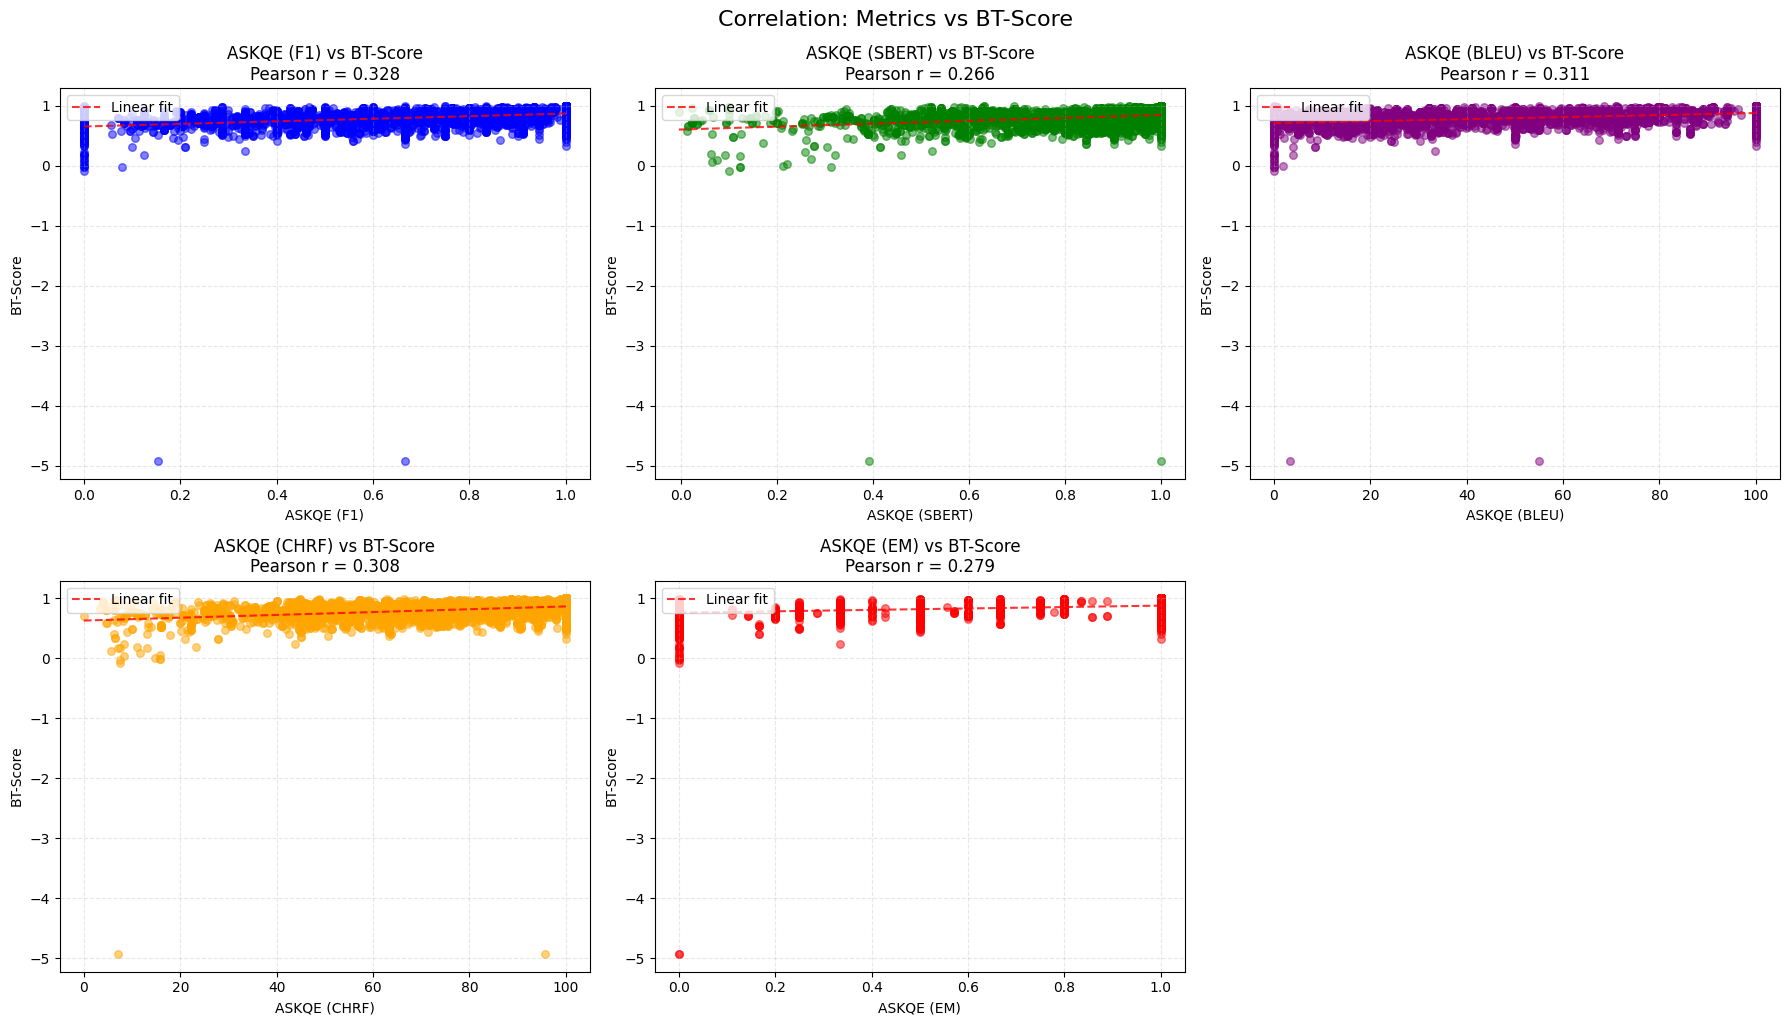

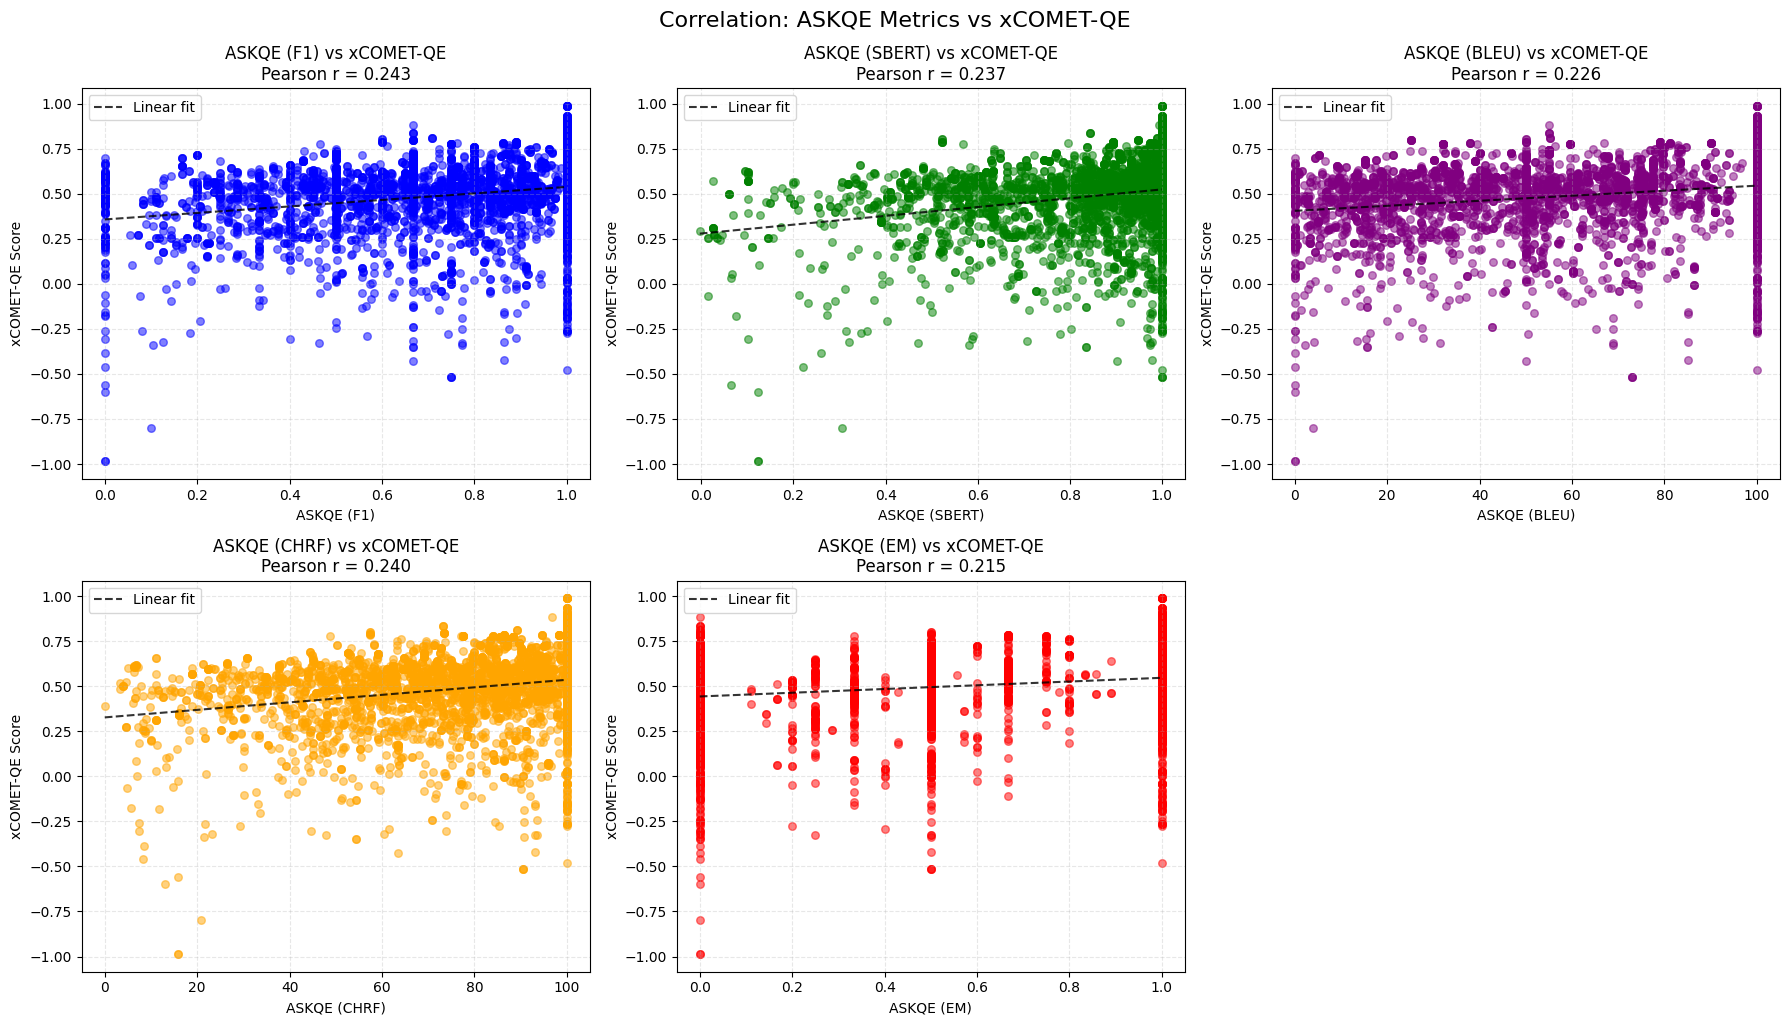

In [ ]:
from scipy.stats import pearsonr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df_results = pd.DataFrame(results)

metrics_to_analyze = {
    'ASKQE (F1)':    'askqe_f1',
    'ASKQE (SBERT)': 'askqe_sbert',
    'ASKQE (BLEU)':  'askqe_bleu',
    'ASKQE (CHRF)':  'askqe_chrf',
    'ASKQE (EM)':    'askqe_em',
    'xCOMET-QE':     'xcomet_score'
}

plot_config = [
    ('ASKQE (F1)',    'askqe_f1',    'blue'),
    ('ASKQE (SBERT)', 'askqe_sbert', 'green'),
    ('ASKQE (BLEU)',  'askqe_bleu',  'purple'),
    ('ASKQE (CHRF)',  'askqe_chrf',  'orange'),
    ('ASKQE (EM)',    'askqe_em',    'red'),
    ('xCOMET-QE',     'xcomet_score','brown')
]

print("\n" + "="*60)
print("Pearson Correlation Analysis: Metrics vs BT-Score")
print("="*60)

for label, col in metrics_to_analyze.items():

    if col == 'xcomet_score':
        continue

    corr, p_val = pearsonr(df_results[col], df_results['bt_score'])
    sig = "Significant" if p_val < 0.05 else "Not Significant"

    print(f"\n{label} vs BT-Score:")
    print(f"  Pearson r = {corr:.4f}")
    print(f"  p-value   = {p_val:.4e} ({sig})")

plot_config_fig1 = [item for item in plot_config if item[1] != 'xcomet_score']

fig1, axes1 = plt.subplots(2, 3, figsize=(18, 10))
if isinstance(axes1, np.ndarray): axes1 = axes1.flatten()

for i, (label, col, color) in enumerate(plot_config_fig1):
    ax = axes1[i]

    x_data = df_results[col]

    ax.scatter(x_data, df_results['bt_score'], alpha=0.5, s=30, color=color)

    z = np.polyfit(df_results[col], df_results['bt_score'], 1)
    p = np.poly1d(z)
    x_line = np.linspace(df_results[col].min(), df_results[col].max(), 100)
    ax.plot(x_line, p(x_line), 'r--', alpha=0.8, label='Linear fit')

    corr, _ = pearsonr(df_results[col], df_results['bt_score'])
    ax.set_title(f'{label} vs BT-Score\nPearson r = {corr:.3f}')

    ax.set_xlabel(label)
    ax.set_ylabel('BT-Score')
    ax.legend(loc='upper left')
    ax.grid(True, linestyle='--', alpha=0.3)

for j in range(len(plot_config_fig1), len(axes1)):
    fig1.delaxes(axes1[j])

plt.tight_layout()
plt.suptitle('Correlation: Metrics vs BT-Score', y=1.02, fontsize=16)


print("\n" + "="*60)
print("Pearson Correlation Analysis: ASKQE Metrics vs xCOMET-QE")
print("="*60)

askqe_metrics_only = {k: v for k, v in metrics_to_analyze.items() if v != 'xcomet_score'}

for label, col in askqe_metrics_only.items():

    corr, p_val = pearsonr(df_results[col], df_results['xcomet_score'])

    sig = "Significant" if p_val < 0.05 else "Not Significant"
    print(f"\n{label} vs xCOMET-QE:")
    print(f"  Pearson r = {corr:.4f}")
    print(f"  p-value   = {p_val:.4e} ({sig})")

plot_config_fig2 = plot_config_fig1

fig2, axes2 = plt.subplots(2, 3, figsize=(18, 10))
if isinstance(axes2, np.ndarray): axes2 = axes2.flatten()

for i, (label, col, color) in enumerate(plot_config_fig2):
    ax = axes2[i]

    x_data = df_results[col]

    ax.scatter(x_data, df_results['xcomet_score'], alpha=0.5, s=30, color=color)

    z = np.polyfit(df_results[col], df_results['xcomet_score'], 1)
    p = np.poly1d(z)
    x_line = np.linspace(df_results[col].min(), df_results[col].max(), 100)
    ax.plot(x_line, p(x_line), 'k--', alpha=0.8, label='Linear fit')

    corr, _ = pearsonr(df_results[col], df_results['xcomet_score'])
    ax.set_title(f'{label} vs xCOMET-QE\nPearson r = {corr:.3f}')

    ax.set_xlabel(label)
    ax.set_ylabel('xCOMET-QE Score')
    ax.legend(loc='upper left')
    ax.grid(True, linestyle='--', alpha=0.3)

for j in range(len(plot_config_fig2), len(axes2)):
    fig2.delaxes(axes2[j])

plt.tight_layout()
plt.suptitle('Correlation: ASKQE Metrics vs xCOMET-QE', y=1.02, fontsize=16)

plt.show()

##GMM

Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x7b599de32480>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/threadpoolctl.py", line 1005, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/usr/local/lib/python3.12/dist-packages/threadpoolctl.py", line 1187, in _make_controller_from_path
    lib_controller = controller_class(
                     ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/threadpoolctl.py", line 114, in __init__
    self.dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/ctypes/__init__.py", line 379, in __init__
    self._handle = _dlopen(self._name, mode)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^
OSError: /usr/local/lib/python3.12/dist-packages/numpy.libs/libscipy_openblas64_-99b71e


--- GMM Decision Accuracy ---
F1: 41.55% (Acc μ: 1.000, Rej μ: 0.611)
BLEURT: 39.46% (Acc μ: 100.000, Rej μ: 44.783)
CHRF: 39.46% (Acc μ: 100.000, Rej μ: 69.009)
EM: 55.88% (Acc μ: 0.757, Rej μ: 0.000)
SBERT: 41.53% (Acc μ: 1.000, Rej μ: 0.790)
BERTScore: 77.76% (Acc μ: 0.821, Rej μ: 0.100)
COMET: 73.76% (Acc μ: 0.547, Rej μ: 0.247)


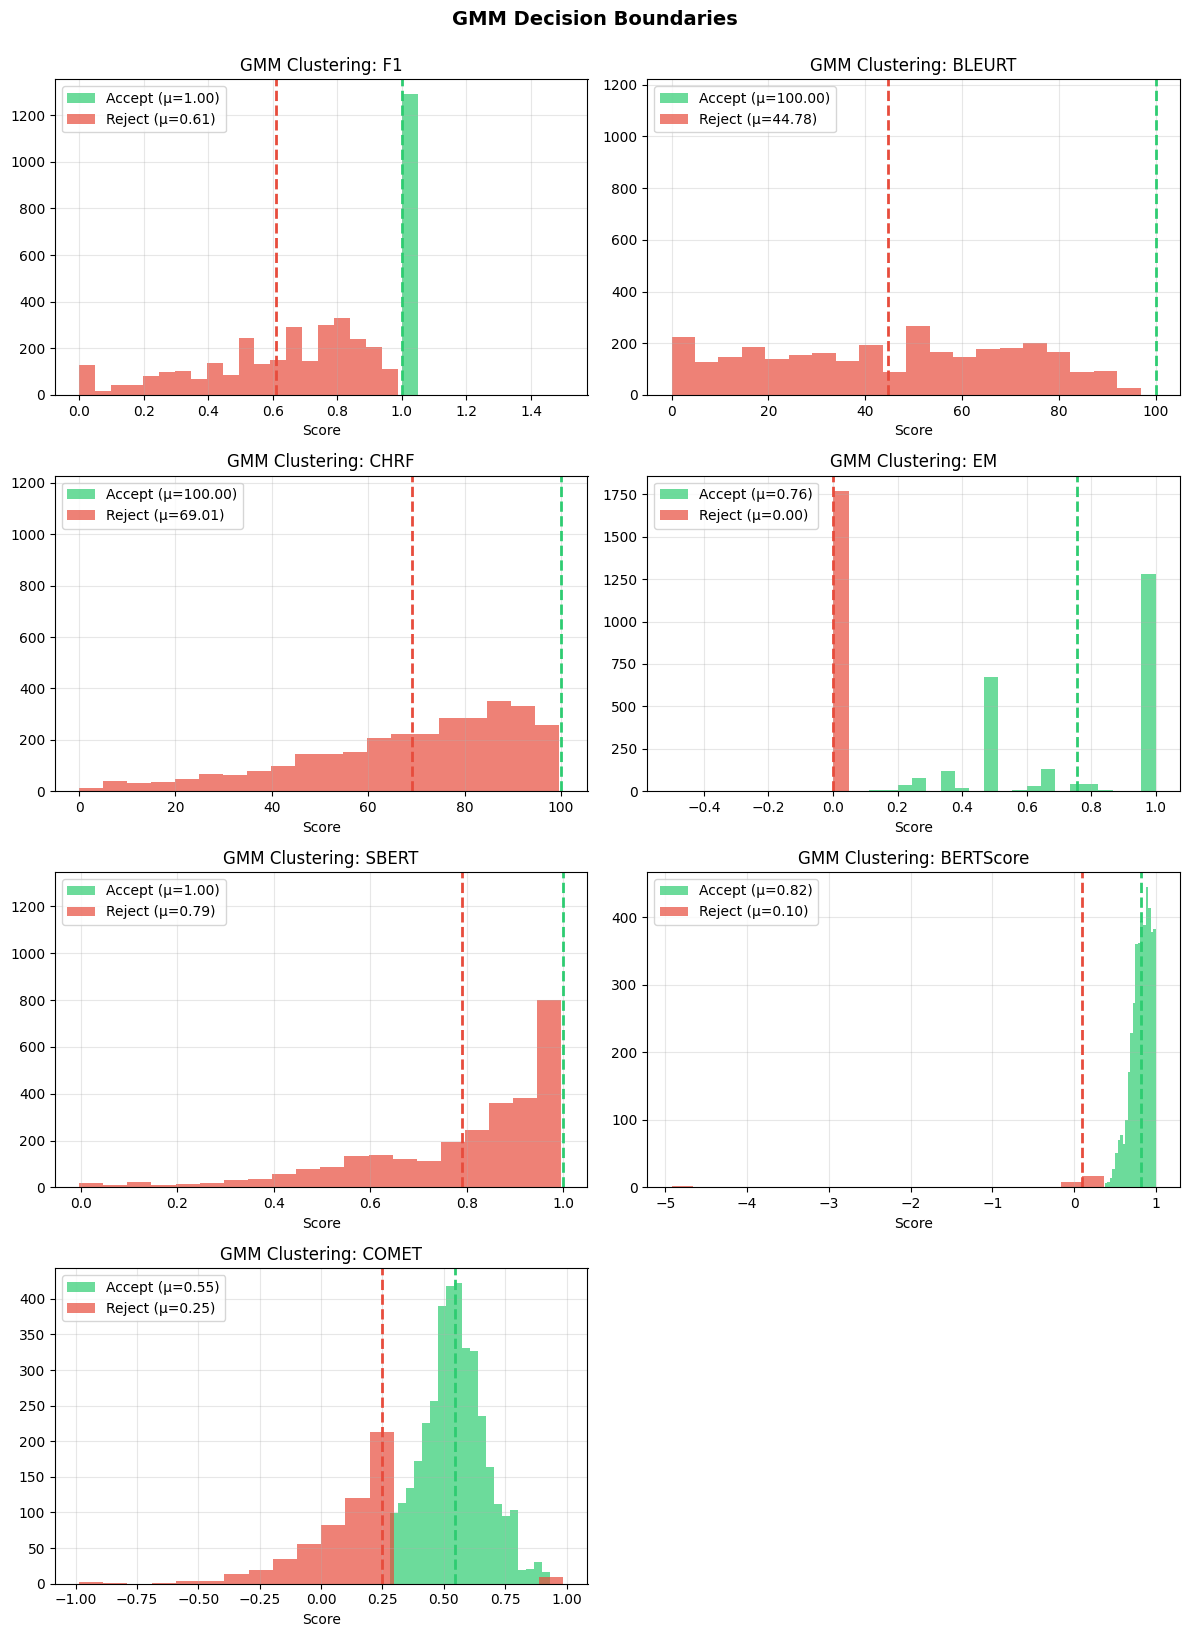

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

def get_human_labels(df):
    """Generates ground truth booleans (Accept=True) from severity strings."""
    valid_severities = {'no error', 'neutral', 'minor', 'none'}
    return df['severity'].astype(str).str.lower().isin(valid_severities)

def fit_gmm(data):
    """Fits a 2-component GMM and returns the model, means, and cluster assignments."""
    X = data.values.reshape(-1, 1)
    gmm = GaussianMixture(n_components=2, random_state=42).fit(X)

    means = gmm.means_.flatten()
    accept_idx = np.argmax(means)  # The cluster with higher score is "Accept"
    labels = gmm.predict(X)

    return means, accept_idx, labels

def evaluate_metric(df, col, name):
    """Calculates decision accuracy for a single metric."""

    # Get GMM predictions
    means, accept_idx, labels = fit_gmm(df[col])
    pred_accept = (labels == accept_idx)

    # Compare with ground truth
    human_accept = get_human_labels(df)
    accuracy = np.mean(pred_accept == human_accept) * 100

    print(f"{name}: {accuracy:.2f}% (Acc μ: {means[accept_idx]:.3f}, Rej μ: {means[1-accept_idx]:.3f})")
    return accuracy

def plot_clusters(df, metrics):
    """Visualizes GMM clusters for all valid metrics."""
    valid_metrics = [(c, n) for c, n in metrics if c in df.columns]

    n = len(valid_metrics)
    cols = 2
    rows = (n + 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(12, 4 * rows))
    axes = np.array(axes).flatten()

    for ax, (col, name) in zip(axes, valid_metrics):
        X = df[col].values

        means, accept_idx, labels = fit_gmm(df[col])
        reject_idx = 1 - accept_idx

        # Plot histograms for both clusters
        for idx, color, label in [(accept_idx, '#2ecc71', 'Accept'), (reject_idx, '#e74c3c', 'Reject')]:
            subset = X[labels == idx]
            ax.hist(subset, bins=20, alpha=0.7, color=color, label=f'{label} (μ={means[idx]:.2f})')
            ax.axvline(means[idx], color=color, linestyle='--', linewidth=2)

        ax.set_title(f'GMM Clustering: {name}')
        ax.set_xlabel('Score')
        ax.legend()
        ax.grid(alpha=0.3)

    # Clean up empty subplots
    for ax in axes[n:]: fig.delaxes(ax)

    plt.tight_layout()
    plt.suptitle('GMM Decision Boundaries', y=1.02, fontsize=14, fontweight='bold')
    plt.show()

metrics = [
    ('askqe_f1', 'F1'), ('askqe_bleu', 'BLEURT')
    ,('askqe_chrf', 'CHRF'), ('askqe_em', 'EM')
    ,('askqe_sbert', 'SBERT')
    ,('bt_score', 'BERTScore'), ('xcomet_score', 'COMET')
]

print("\n--- GMM Decision Accuracy ---")
results = {name: evaluate_metric(df_results, col, name) for col, name in metrics}

plot_clusters(df_results, metrics)

# Ablation module
This section adds 4 ablation experiments **without modifying the baseline code above**.

Goal: compare **baseline vs exp1–exp4** on the same data and produce a compact comparison table.

Notes:
- We re-use the same `dataset_clean`, `generate_text_batch`, `SAMPLING_PARAMS`, and model (`llm`) defined above.
- Each experiment stores its own `results_*` list with the same structure as `results` (when possible).


In [ ]:

import time
import json
import numpy as np
import pandas as pd
from sacrebleu import sentence_chrf
from sentence_transformers import util
import scipy.stats

def _now():
    return time.time()

def _safe_json_loads(s, default=None):
    if default is None:
        default = []
    try:
        return json.loads(s)
    except Exception:
        return default

def _parse_list_output_simple(text):
    """
    Baseline already has parse_list_output(). This is a small fallback for ablation runs.
    It tries to extract a Python-style list from the model output.
    """
    try:
        import ast
        start = text.find('[')
        end = text.rfind(']') + 1
        if start != -1 and end != -1:
            return ast.literal_eval(text[start:end])
        return []
    except Exception:
        return []

def _ensure_results_loaded():
    # baseline stores into `results` and also writes `askqe_data.jsonl`.
    if "results" in globals() and isinstance(results, list) and len(results) > 0:
        return results
    try:
        tmp = []
        with open("askqe_data.jsonl", "r") as f:
            for line in f:
                tmp.append(json.loads(line))
        return tmp
    except Exception:
        raise ValueError("Baseline results not found. Run the baseline pipeline above first (it should produce `results`).")

def _flatten_answers(ans_list):
    if ans_list is None:
        return []
    out = []
    for a in ans_list:
        if isinstance(a, list):
            out.append(" ".join([str(x) for x in a]))
        else:
            out.append(str(a))
    return out

def _compute_pair_metrics(answers_src, answers_bt):
    """
    Per-item metrics between SRC-answers and BT-answers:
      - EM (exact match)
      - chrF (sentence_chrf)
      - SBERT cosine (MiniLM, if sbert_model exists)
    """
    a_src = _flatten_answers(answers_src)
    a_bt  = _flatten_answers(answers_bt)
    m = min(len(a_src), len(a_bt))
    a_src, a_bt = a_src[:m], a_bt[:m]
    if m == 0:
        return {"n_pairs": 0, "em": 0.0, "chrf": 0.0, "sbert": 0.0}

    em = np.mean([1.0 if a_src[i].strip() == a_bt[i].strip() else 0.0 for i in range(m)])
    chrf = np.mean([sentence_chrf(a_bt[i], [a_src[i]]).score / 100.0 for i in range(m)])

    if "sbert_model" in globals():
        emb_src = sbert_model.encode(a_src, convert_to_tensor=True, show_progress_bar=False)
        emb_bt  = sbert_model.encode(a_bt,  convert_to_tensor=True, show_progress_bar=False)
        sims = util.cos_sim(emb_src, emb_bt).diagonal().cpu().numpy()
        sbert = float(np.mean(sims))
    else:
        sbert = 0.0

    return {"n_pairs": m, "em": float(em), "chrf": float(chrf), "sbert": float(sbert)}

def _kendall_tau(xs, ys):
    xs = np.array(xs, dtype=float)
    ys = np.array(ys, dtype=float)
    mask = ~np.isnan(xs) & ~np.isnan(ys)
    if mask.sum() < 3:
        return np.nan, np.nan
    tau, p = scipy.stats.kendalltau(xs[mask], ys[mask])
    return float(tau), float(p)

def summarize_run(run_name, run_results, score_key="askqe_score"):
    mqm = []
    score = []
    facts_n = []
    q_n = []
    atoms_n = []
    empty_q = 0
    empty_f = 0

    for r in run_results:
        mqm_score = r.get("mqm_score", None)
        if mqm_score is None:
            continue
        mqm.append(float(mqm_score))
        score.append(float(r.get(score_key, 0.0)))

        facts = r.get("facts", []) or []
        qs = r.get("questions", []) or []
        atoms = r.get("atoms", []) or []

        facts_n.append(len(facts))
        q_n.append(len(qs))
        atoms_n.append(len(atoms))

        if len(qs) == 0:
            empty_q += 1
        if len(facts) == 0:
            empty_f += 1

    tau, p = _kendall_tau(score, mqm)
    return {
        "run": run_name,
        "n": len(run_results),
        "mean_score": float(np.mean(score)) if len(score) else np.nan,
        "tau_vs_mqm": tau,
        "p_value": p,
        "avg_facts": float(np.mean(facts_n)) if len(facts_n) else 0.0,
        "avg_questions": float(np.mean(q_n)) if len(q_n) else 0.0,
        "avg_atoms": float(np.mean(atoms_n)) if len(atoms_n) else 0.0,
        "empty_fact_rows": empty_f,
        "empty_question_rows": empty_q,
    }


## Ablation parameters
You can reduce the runtime by limiting the number of samples.  
By default we use the full `dataset_clean`.


In [ ]:
MAX_SAMPLES_ABL = None   # e.g. 200 for a quick run; None = all
BATCH_SIZE_ABL = 32      # used for batching prompts (we still call generate_text_batch)


## Experiment 1: no atomic facts + no NLI (questions directly from sentence)
We skip fact extraction and NLI. We ask the LLM to generate questions directly from the source sentence, then answer them on `source` and `backtranslation`.


In [ ]:
def run_exp1_questions_direct(max_samples=MAX_SAMPLES_ABL):
    base = _ensure_results_loaded()
    data = dataset_clean[:max_samples] if max_samples is not None else dataset_clean

    t0 = _now()

    # 1) Question generation directly from sentence
    qg_prompts = []
    idx_map = []
    for i, e in enumerate(data):
        src = e.get("source", "")
        if not src:
            continue
        p = f"""
You are given a single English sentence.
Generate 3-6 short factual questions that can be answered directly from the sentence.
Return ONLY a python list of strings.

Sentence:
{src}
"""
        qg_prompts.append(p)
        idx_map.append(i)

    qg_out = generate_text_batch(qg_prompts, SAMPLING_PARAMS)

    all_questions = [[] for _ in range(len(data))]
    for out, i in zip(qg_out, idx_map):
        qs = parse_list_output(out) if "parse_list_output" in globals() else _parse_list_output_simple(out)
        if isinstance(qs, list):
            all_questions[i] = [str(x) for x in qs][:8]

    # 2) QA on SRC and BT
    prompts_qa_src, prompts_qa_bt, qa_idx_map = [], [], []
    for i, e in enumerate(data):
        qs = all_questions[i]
        if not qs:
            continue

        p_src = qa_prompt_template.replace("{{sentence}}", e.get("source", "")).replace("{{questions}}", str(qs))
        p_bt  = qa_prompt_template.replace("{{sentence}}", e.get("backtranslation", "")).replace("{{questions}}", str(qs))

        prompts_qa_src.append(p_src)
        prompts_qa_bt.append(p_bt)
        qa_idx_map.append(i)

    all_ans = generate_text_batch(prompts_qa_src + prompts_qa_bt, SAMPLING_PARAMS)
    split = len(prompts_qa_src)
    ans_src = all_ans[:split]
    ans_bt  = all_ans[split:]

    all_answers_src = [[] for _ in range(len(data))]
    all_answers_bt  = [[] for _ in range(len(data))]
    for pos, i in enumerate(qa_idx_map):
        all_answers_src[i] = [ans_src[pos]]
        all_answers_bt[i]  = [ans_bt[pos]]

    # 3) Score: compare answers_src vs answers_bt
    run_results = []
    for i, e in enumerate(data):
        pair_m = _compute_pair_metrics(all_answers_src[i], all_answers_bt[i])
        score = pair_m["chrf"]  # 0..1
        run_results.append({
            "id": e.get("id", i),
            "source": e.get("source", ""),
            "backtranslation": e.get("backtranslation", ""),
            "facts": [],
            "questions": all_questions[i],
            "answers_src": all_answers_src[i],
            "answers_bt": all_answers_bt[i],
            "askqe_score": float(score),
            "mqm_score": e.get("mqm_score", None),
            "severity": e.get("severity", None),
        })

    t1 = _now()
    summary = summarize_run("exp1_questions_direct", run_results, score_key="askqe_score")
    summary["runtime_sec"] = round(t1 - t0, 2)
    return run_results, summary

results_exp1, summary_exp1 = run_exp1_questions_direct()
pd.DataFrame([summary_exp1])


Adding requests:   0%|          | 0/5000 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/5000 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s…

Adding requests:   0%|          | 0/9584 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/9584 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s…

,run,n,mean_score,tau_vs_mqm,p_value,avg_facts,avg_questions,avg_atoms,empty_fact_rows,empty_question_rows,runtime_sec
0,exp1_questions_direct,5000,0.72471,0.078556,7.480435e-14,0.0,3.2138,0.0,5000,208,347.27


## Experiment 2: no NLI (keep atomic facts, but do not filter contradictions)
We keep the atomic-fact extraction prompt, but skip the NLI filtering step.
Then we do question generation + QA like baseline.


In [ ]:
def run_exp2_no_nli(max_samples=MAX_SAMPLES_ABL):
    data = dataset_clean[:max_samples] if max_samples is not None else dataset_clean

    t0 = _now()

    # Phase 1: atomic facts (no NLI)
    af_prompts = [atomic_fact_prompt_template.replace("{{sentence}}", e.get("source", "")) for e in data]
    af_out = generate_text_batch(af_prompts, SAMPLING_PARAMS)

    all_facts = []
    for out in af_out:
        facts = parse_list_output(out) if "parse_list_output" in globals() else _parse_list_output_simple(out)
        if not isinstance(facts, list):
            facts = []
        all_facts.append([str(x) for x in facts][:12])

    # Phase 2: question generation from facts (baseline template)
    qg_prompts, idx_map = [], []
    for i, e in enumerate(data):
        facts = all_facts[i]
        if not facts:
            continue
        p = qg_prompt_template.replace("{{sentence}}", e.get("source", "")).replace("{{atomic_facts}}", str(facts))
        qg_prompts.append(p)
        idx_map.append(i)

    qg_out = generate_text_batch(qg_prompts, SAMPLING_PARAMS)
    all_questions = [[] for _ in range(len(data))]
    for out, i in zip(qg_out, idx_map):
        qs = parse_list_output(out) if "parse_list_output" in globals() else _parse_list_output_simple(out)
        if isinstance(qs, list):
            all_questions[i] = [str(x) for x in qs][:8]

    # Phase 3: QA
    prompts_qa_src, prompts_qa_bt, qa_idx_map = [], [], []
    for i, e in enumerate(data):
        qs = all_questions[i]
        if not qs:
            continue
        p_src = qa_prompt_template.replace("{{sentence}}", e.get("source", "")).replace("{{questions}}", str(qs))
        p_bt  = qa_prompt_template.replace("{{sentence}}", e.get("backtranslation", "")).replace("{{questions}}", str(qs))
        prompts_qa_src.append(p_src)
        prompts_qa_bt.append(p_bt)
        qa_idx_map.append(i)

    all_ans = generate_text_batch(prompts_qa_src + prompts_qa_bt, SAMPLING_PARAMS)
    split = len(prompts_qa_src)
    ans_src = all_ans[:split]
    ans_bt  = all_ans[split:]

    all_answers_src = [[] for _ in range(len(data))]
    all_answers_bt  = [[] for _ in range(len(data))]
    for pos, i in enumerate(qa_idx_map):
        all_answers_src[i] = [ans_src[pos]]
        all_answers_bt[i]  = [ans_bt[pos]]

    run_results = []
    for i, e in enumerate(data):
        pair_m = _compute_pair_metrics(all_answers_src[i], all_answers_bt[i])
        score = pair_m["chrf"]
        run_results.append({
            "id": e.get("id", i),
            "source": e.get("source", ""),
            "backtranslation": e.get("backtranslation", ""),
            "facts": all_facts[i],
            "questions": all_questions[i],
            "answers_src": all_answers_src[i],
            "answers_bt": all_answers_bt[i],
            "askqe_score": float(score),
            "mqm_score": e.get("mqm_score", None),
            "severity": e.get("severity", None),
        })

    t1 = _now()
    summary = summarize_run("exp2_no_nli", run_results, score_key="askqe_score")
    summary["runtime_sec"] = round(t1 - t0, 2)
    return run_results, summary

results_exp2, summary_exp2 = run_exp2_no_nli()
pd.DataFrame([summary_exp2])


Adding requests:   0%|          | 0/5000 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/5000 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s…

Adding requests:   0%|          | 0/4797 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/4797 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s…

Adding requests:   0%|          | 0/9594 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/9594 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s…

,run,n,mean_score,tau_vs_mqm,p_value,avg_facts,avg_questions,avg_atoms,empty_fact_rows,empty_question_rows,runtime_sec
0,exp2_no_nli,5000,0.720436,0.061429,6.127024e-09,2.4504,2.5274,0.0,203,203,495.73


## Experiment 3: no question generation + no QA (atom coverage checks)
Pipeline:
1) atomic facts
2) NLI (keep as baseline)
3) split each fact into smaller **atoms**
4) check each atom is supported by `source` and by `backtranslation` (yes/no)
5) score = F1 between supported-atoms sets (src = reference, bt = prediction)


In [ ]:
import re
import numpy as np

def _label_id_from_label_str(label: str):
    # "LABEL_0" -> 0
    m = re.search(r"(\d+)$", str(label))
    return int(m.group(1)) if m else None

def calibrate_nli_label_ids(nli_pipeline):
    """
    Infers which LABEL_k corresponds to ENTAILMENT / CONTRADICTION / NEUTRAL
    using 3 synthetic tests.
    Works even if model uses weird id2label mapping.
    """
    tests = [
        ("A cat sits on the mat.", "A cat sits on the mat.", "ENTAIL"),      # should be entailment
        ("A cat sits on the mat.", "A dog sits on the mat.", "CONTR"),      # likely contradiction
        ("A cat sits on the mat.", "An animal exists.",       "NEUTRALish") # often neutral/entail depending; used only as tie-breaker
    ]

    preds = []
    for prem, hyp, tag in tests:
        out = nli_pipeline([{"text": prem, "text_pair": hyp}], truncation=True, max_length=128)[0]
        lid = _label_id_from_label_str(out.get("label"))
        preds.append((tag, lid, float(out.get("score", 0.0)), out.get("label")))

    # entailment id = label id for identical sentence
    entail_id = [lid for tag,lid,sc,lab in preds if tag=="ENTAIL"][0]

    # contradiction id = label id for cat vs dog (if different)
    contr_id = [lid for tag,lid,sc,lab in preds if tag=="CONTR"][0]

    # neutral id = the remaining one among {0,1,2} if possible
    cand = {0,1,2}
    if entail_id in cand and contr_id in cand:
        neutral_ids = list(cand - {entail_id, contr_id})
        neutral_id = neutral_ids[0] if neutral_ids else None
    else:
        neutral_id = None

    print("[NLI calibration] raw predictions:", preds)
    print(f"[NLI calibration] entail_id={entail_id}, contr_id={contr_id}, neutral_id={neutral_id}")
    return entail_id, contr_id, neutral_id

ENTAIL_ID, CONTR_ID, NEUTRAL_ID = calibrate_nli_label_ids(nli_pipeline)

def is_entailment(res, entail_id=ENTAIL_ID, min_score=0.0):
    lid = _label_id_from_label_str(res.get("label"))
    sc = float(res.get("score", 0.0))
    return (lid == entail_id) and (sc >= min_score)

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


[NLI calibration] raw predictions: [('ENTAIL', 0, 0.9997063279151917, 'LABEL_0'), ('CONTR', 1, 0.9994608759880066, 'LABEL_1'), ('NEUTRALish', 1, 0.9284524917602539, 'LABEL_1')]
[NLI calibration] entail_id=0, contr_id=1, neutral_id=2


In [ ]:
import pandas as pd

def run_exp3_atoms_coverage(max_samples=MAX_SAMPLES_ABL, entail_thresh=0.0):
    data = dataset_clean[:max_samples] if max_samples is not None else dataset_clean

    t0 = _now()

    # -------------------------
    # Phase 1: atomic facts
    # -------------------------
    af_prompts = [atomic_fact_prompt_template.replace("{{sentence}}", e.get("source", "")) for e in data]
    af_out = generate_text_batch(af_prompts, SAMPLING_PARAMS)

    raw_facts = []
    for out in af_out:
        facts = parse_list_output(out) if "parse_list_output" in globals() else _parse_list_output_simple(out)
        if not isinstance(facts, list):
            facts = []
        raw_facts.append([str(x) for x in facts][:12])

    # -------------------------
    # Phase 1b: NLI filtering (baseline-like)
    # -------------------------
    flat_inputs = []
    for i, facts in enumerate(raw_facts):
        if not facts:
            continue
        src = data[i].get("source", "")
        for fact in facts:
            flat_inputs.append((i, fact, src))

    all_facts = [[] for _ in range(len(data))]
    if flat_inputs:
        nli_pairs = [{"text": t[2], "text_pair": t[1]} for t in flat_inputs]
        nli_results = nli_pipeline(nli_pairs, batch_size=64, truncation=True, max_length=512)

        for (i, fact, src), res in zip(flat_inputs, nli_results):
            # keep fact if NOT contradiction (same as baseline logic)
            # baseline in твоём коде был странный на LABEL_1, но давай оставим твою идею:
            # мы фильтруем только "жёсткие" противоречия
            # => contradiction = CONTR_ID (из калибровки)
            lid = _label_id_from_label_str(res.get("label"))
            if lid != CONTR_ID:
                all_facts[i].append(fact)
    else:
        all_facts = raw_facts

    # -------------------------
    # Phase 2: split to smaller atoms
    # -------------------------
    atom_prompts, idx_map = [], []
    for i, facts in enumerate(all_facts):
        if not facts:
            continue
        p = f"""
You are given a list of atomic facts (may still contain multiple claims).
Split them into the smallest independent claims ("atoms") so each atom is a short statement.
Return ONLY a python list of strings. Max 12 atoms.

Atomic facts:
{facts}
"""
        atom_prompts.append(p)
        idx_map.append(i)

    atom_out = generate_text_batch(atom_prompts, SAMPLING_PARAMS)

    all_atoms = [[] for _ in range(len(data))]
    for out, i in zip(atom_out, idx_map):
        atoms = parse_list_output(out) if "parse_list_output" in globals() else _parse_list_output_simple(out)
        if isinstance(atoms, list):
            all_atoms[i] = [str(x) for x in atoms if str(x).strip()][:12]

    # -------------------------
    # Phase 3: NLI support checks (src & bt) for each atom
    # -------------------------
    chk_pairs = []
    chk_meta = []  # (i, side, atom_index)

    for i, e in enumerate(data):
        atoms = all_atoms[i]
        if not atoms:
            continue

        src = e.get("source", "") or ""
        bt  = e.get("backtranslation", "") or ""

        for j, atom in enumerate(atoms):
            chk_pairs.append({"text": src, "text_pair": atom})
            chk_meta.append((i, "src", j))

            chk_pairs.append({"text": bt, "text_pair": atom})
            chk_meta.append((i, "bt", j))

    supported_src = [set() for _ in range(len(data))]
    supported_bt  = [set() for _ in range(len(data))]

    answers_src_yesno = [[] for _ in range(len(data))]
    answers_bt_yesno  = [[] for _ in range(len(data))]

    if chk_pairs:
        chk_out = nli_pipeline(chk_pairs, batch_size=64, truncation=True, max_length=512)

        # initialize yes/no arrays aligned with atoms
        for i, atoms in enumerate(all_atoms):
            if atoms:
                answers_src_yesno[i] = ["no"] * len(atoms)
                answers_bt_yesno[i]  = ["no"] * len(atoms)

        for res, (i, side, j) in zip(chk_out, chk_meta):
            if is_entailment(res, min_score=entail_thresh):
                if side == "src":
                    supported_src[i].add(j)
                    answers_src_yesno[i][j] = "yes"
                else:
                    supported_bt[i].add(j)
                    answers_bt_yesno[i][j] = "yes"

    # -------------------------
    # Scoring: F1 between supported indices
    # -------------------------
    def _f1(ref_set, pred_set):
        if len(ref_set) == 0 and len(pred_set) == 0:
            return 1.0
        if len(ref_set) == 0 and len(pred_set) > 0:
            return 0.0
        tp = len(ref_set & pred_set)
        fp = len(pred_set - ref_set)
        fn = len(ref_set - pred_set)
        prec = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        rec  = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        return 2*prec*rec/(prec+rec) if (prec+rec) > 0 else 0.0

    run_results = []
    for i, e in enumerate(data):
        score = _f1(supported_src[i], supported_bt[i])
        run_results.append({
            "id": e.get("id", i),
            "source": e.get("source", ""),
            "backtranslation": e.get("backtranslation", ""),
            "facts": all_facts[i],
            "atoms": all_atoms[i],
            # ✅ чтобы empty_question_rows НЕ было 5000:
            "questions": all_atoms[i],               # трактуем atoms как "items to check"
            "answers_src": answers_src_yesno[i],     # yes/no по atoms
            "answers_bt": answers_bt_yesno[i],
            "askqe_score": float(score),
            "mqm_score": e.get("mqm_score", None),
            "severity": e.get("severity", None),
        })

    t1 = _now()
    summary = summarize_run("exp3_atoms_coverage_fixed", run_results, score_key="askqe_score")
    summary["runtime_sec"] = round(t1 - t0, 2)

    # полезные доп.статы для дебага
    avg_src_sup = np.mean([len(s) for s in supported_src]) if supported_src else 0.0
    avg_bt_sup  = np.mean([len(s) for s in supported_bt]) if supported_bt else 0.0
    summary["avg_src_supported"] = round(float(avg_src_sup), 4)
    summary["avg_bt_supported"]  = round(float(avg_bt_sup), 4)

    return run_results, summary

results_exp3, summary_exp3 = run_exp3_atoms_coverage()
pd.DataFrame([summary_exp3])

Adding requests:   0%|          | 0/5000 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/5000 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s…

Adding requests:   0%|          | 0/3510 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/3510 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s…

,run,n,mean_score,tau_vs_mqm,p_value,avg_facts,avg_questions,avg_atoms,empty_fact_rows,empty_question_rows,runtime_sec,avg_src_supported,avg_bt_supported
0,exp3_atoms_coverage_fixed,5000,0.894876,0.019494,0.111039,1.114,2.6596,2.6596,1490,1575,707.84,1.6268,1.5376


In [ ]:
# pick 3 random samples with atoms non-empty from your exp3 data
import random, numpy as np

def debug_nli_on_atoms(sample_idx=0):
    e = dataset_clean[sample_idx]
    src = e.get("source","")
    bt  = e.get("backtranslation","")

    # quick atoms: just use facts as "atoms" for debugging
    af_prompt = atomic_fact_prompt_template.replace("{{sentence}}", src)
    af_raw = generate_text_batch([af_prompt], SAMPLING_PARAMS)[0]
    facts = parse_list_output(af_raw)
    facts = [str(x) for x in facts][:5]

    print("SRC:", src[:200])
    print("BT :", bt[:200])
    print("FACTS:", facts)

    if not facts:
        print("No facts, stop.")
        return

    pairs = []
    meta = []
    for j, atom in enumerate(facts):
        pairs.append({"text": src, "text_pair": atom}); meta.append(("src", j, atom))
        pairs.append({"text": bt,  "text_pair": atom}); meta.append(("bt",  j, atom))

    out = nli_pipeline(pairs, batch_size=8, truncation=True, max_length=512)
    for m, r in zip(meta, out):
        side, j, atom = m
        print(f"{side} atom{j} | label={r['label']} score={r['score']:.3f} | {atom}")

# try a few indices
debug_nli_on_atoms(0)
debug_nli_on_atoms(10)
debug_nli_on_atoms(50)

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

SRC: Three cases of cervicofacial NF are presented in this case report.
BT : This case report presents three cases of cervicofacial NF.
FACTS: ['Three cases of cervicofacial NF are presented in this case report.']
src atom0 | label=LABEL_0 score=0.998 | Three cases of cervicofacial NF are presented in this case report.
bt atom0 | label=LABEL_0 score=1.000 | Three cases of cervicofacial NF are presented in this case report.


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

SRC: Laboratory parameters (Laboratory Risk Indicator for Necrotizing Fasciitis [LRINEC] score) and imaging via CT or MRT are helpful.
BT : Laboratory parameters (Laboratory Risk Indicator for Necrotizing Fasciitis [LRINEC] score) and imaging using CT or MRI are helpful.
FACTS: ['Laboratory parameters (Laboratory Risk Indicator for Necrotizing Fasciitis [LRINEC] score) are helpful.', 'Imaging via CT or MRT is helpful.']
src atom0 | label=LABEL_1 score=0.767 | Laboratory parameters (Laboratory Risk Indicator for Necrotizing Fasciitis [LRINEC] score) are helpful.
bt atom0 | label=LABEL_1 score=0.769 | Laboratory parameters (Laboratory Risk Indicator for Necrotizing Fasciitis [LRINEC] score) are helpful.
src atom1 | label=LABEL_0 score=0.996 | Imaging via CT or MRT is helpful.
bt atom1 | label=LABEL_0 score=0.995 | Imaging via CT or MRT is helpful.


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

SRC: (90 %) by means of antegrade push-technique after balloon dilatation of the papilla of Vater and biliodigestive anastomosis, respectively, before.
BT : (90%) using antegrade push technique after balloon dilatation of the Vater papilla or biliodigestive anastomosis.
FACTS: ['(90\u200a%) by means of antegrade push-technique after balloon dilatation of the papilla of Vater and biliodigestive anastomosis, respectively, before.']
src atom0 | label=LABEL_0 score=0.921 | (90 %) by means of antegrade push-technique after balloon dilatation of the papilla of Vater and biliodigestive anastomosis, respectively, before.
bt atom0 | label=LABEL_0 score=0.983 | (90 %) by means of antegrade push-technique after balloon dilatation of the papilla of Vater and biliodigestive anastomosis, respectively, before.


## Experiment 4: combined question generation + answering (single prompt)
After atomic facts extraction (and NLI), we do QG+QA in **one** model call:
- generate questions from facts
- answer them from SRC
- answer them from BT


In [ ]:
import json
import re
import numpy as np

# -------------------------
# JSON helpers for exp4
# -------------------------
def _extract_json_obj(text: str):
    """Try to extract the first {...} JSON object from a messy generation."""
    if not text:
        return None
    start = text.find("{")
    end = text.rfind("}")
    if start == -1 or end == -1 or end <= start:
        return None
    return text[start:end+1]

def _safe_json_loads(text: str, default=None):
    if default is None:
        default = {}
    cand = _extract_json_obj(text)
    if not cand:
        return default
    try:
        return json.loads(cand)
    except Exception:
        return default

def generate_json_batch(prompts, sampling_params):
    """
    vLLM generation for JSON outputs (NO forced '[' hacks).
    Uses same ChatML wrapper but does not inject '['.
    """
    if not prompts:
        return []

    # если у тебя есть SYSTEM_PROMPT — можно оставить, но важно НЕ форсить '['
    # минимальный вариант:
    formatted = []
    for p in prompts:
        formatted.append(
            "<|im_start|>system\n"
            "You must output ONLY valid JSON. No extra text.\n"
            "<|im_end|>\n"
            "<|im_start|>user\n"
            + p +
            "\n<|im_end|>\n"
            "<|im_start|>assistant\n"
        )

    outs = llm.generate(formatted, sampling_params)

    texts = []
    for o in outs:
        t = o.outputs[0].text if (o.outputs and len(o.outputs) > 0) else ""
        texts.append((t or "").strip())
    return texts


# -------------------------
# EXP4 fixed
# -------------------------
def run_exp4_qg_qa_combined(max_samples=MAX_SAMPLES_ABL):
    data = dataset_clean[:max_samples] if max_samples is not None else dataset_clean
    t0 = _now()

    # Phase 1: atomic facts
    af_prompts = [atomic_fact_prompt_template.replace("{{sentence}}", e.get("source", "")) for e in data]
    af_out = generate_text_batch(af_prompts, SAMPLING_PARAMS)
    raw_facts = []
    for out in af_out:
        facts = parse_list_output(out) if "parse_list_output" in globals() else _parse_list_output_simple(out)
        if not isinstance(facts, list):
            facts = []
        raw_facts.append([str(x) for x in facts][:12])

    # NLI filtering
    flat_inputs = []
    for i, facts in enumerate(raw_facts):
        if not facts:
            continue
        src = data[i].get("source", "")
        for fact in facts:
            flat_inputs.append((i, fact, src))

    all_facts = [[] for _ in range(len(data))]
    if flat_inputs:
        nli_pairs = [{"text": t[2], "text_pair": t[1]} for t in flat_inputs]
        nli_results = nli_pipeline(nli_pairs, batch_size=64, truncation=True, max_length=512)

        for (i, fact, src), res in zip(flat_inputs, nli_results):
            label = str(res.get("label", "")).upper()
            score = float(res.get("score", 0.0))
            if ("LABEL_1" not in label) or ("LABEL_1" in label and score < 0.85):
                all_facts[i].append(fact)
    else:
        all_facts = raw_facts

    # Combined QG+QA prompt
    comb_prompts, idx_map = [], []
    for i, e in enumerate(data):
        facts = all_facts[i]
        if not facts:
            continue
        src = e.get("source","")
        bt  = e.get("backtranslation","")
        p = f"""
You are given:
- a source sentence (SRC)
- a backtranslation sentence (BT)
- a list of atomic facts extracted from SRC

Task:
1) Generate 3-6 factual questions based on the atomic facts.
2) Answer each question using ONLY SRC.
3) Answer each question using ONLY BT.

STRICT FORMAT:
Return ONLY valid JSON exactly like:
{{"questions":[...], "answers_src":[...], "answers_bt":[...]}}

SRC:
{src}

BT:
{bt}

Atomic facts:
{facts}
"""
        comb_prompts.append(p)
        idx_map.append(i)

    # IMPORTANT: use JSON generator (not list-hacked generator)
    comb_out = generate_json_batch(comb_prompts, SAMPLING_PARAMS)

    all_questions = [[] for _ in range(len(data))]
    all_answers_src = [[] for _ in range(len(data))]
    all_answers_bt  = [[] for _ in range(len(data))]

    # Debug example
    if comb_out:
        print("[exp4 debug] RAW example:", comb_out[0][:400])
        print("[exp4 debug] JSON extracted:", _extract_json_obj(comb_out[0])[:400] if _extract_json_obj(comb_out[0]) else None)

    for out, i in zip(comb_out, idx_map):
        js = _safe_json_loads(out, default={})
        qs  = js.get("questions", [])
        a_s = js.get("answers_src", [])
        a_b = js.get("answers_bt", [])

        if isinstance(qs, list):
            all_questions[i] = [str(x) for x in qs][:8]
        if isinstance(a_s, list):
            all_answers_src[i] = [str(x) for x in a_s][:8]
        if isinstance(a_b, list):
            all_answers_bt[i]  = [str(x) for x in a_b][:8]

        # keep alignment: if lengths mismatch -> wipe (как в baseline стиле)
        if len(all_questions[i]) == 0:
            all_answers_src[i] = []
            all_answers_bt[i] = []
        else:
            L = len(all_questions[i])
            if len(all_answers_src[i]) != L or len(all_answers_bt[i]) != L:
                all_answers_src[i] = []
                all_answers_bt[i] = []

    run_results = []
    for i, e in enumerate(data):
        pair_m = _compute_pair_metrics(all_answers_src[i], all_answers_bt[i])
        score = pair_m.get("chrf", 0.0)
        run_results.append({
            "id": e.get("id", i),
            "source": e.get("source", ""),
            "backtranslation": e.get("backtranslation", ""),
            "facts": all_facts[i],
            "questions": all_questions[i],
            "answers_src": all_answers_src[i],
            "answers_bt": all_answers_bt[i],
            "askqe_score": float(score),
            "mqm_score": e.get("mqm_score", None),
            "severity": e.get("severity", None),
        })

    t1 = _now()
    summary = summarize_run("exp4_qgqa_combined", run_results, score_key="askqe_score")
    summary["runtime_sec"] = round(t1 - t0, 2)
    return run_results, summary


# run
results_exp4, summary_exp4 = run_exp4_qg_qa_combined()
pd.DataFrame([summary_exp4])

Adding requests:   0%|          | 0/5000 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/5000 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s…

Adding requests:   0%|          | 0/4466 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/4466 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s…

[exp4 debug] RAW example: {"questions":[
    "How many cases of cervicofacial NF are presented in the case report?",
    "What is the medical condition referred to as cervicofacial NF?",
    "Where are the cases of cervicofacial NF presented in the case report?"
], "answers_src":[
    "Three cases",
    "cervicofacial NF",
    "in this case report"
], "answers_bt":[
    "three cases",
    "cervicofacial NF",
    "in this c
[exp4 debug] JSON extracted: {"questions":[
    "How many cases of cervicofacial NF are presented in the case report?",
    "What is the medical condition referred to as cervicofacial NF?",
    "Where are the cases of cervicofacial NF presented in the case report?"
], "answers_src":[
    "Three cases",
    "cervicofacial NF",
    "in this case report"
], "answers_bt":[
    "three cases",
    "cervicofacial NF",
    "in this c


,run,n,mean_score,tau_vs_mqm,p_value,avg_facts,avg_questions,avg_atoms,empty_fact_rows,empty_question_rows,runtime_sec
0,exp4_qgqa_combined,5000,0.640483,0.093568,2.089565e-18,1.9058,2.3772,0.0,534,990,761.13


## Final comparison: baseline vs exp1–exp4
We compute the same compact summary for baseline and all ablations, then show a single table.


In [ ]:
baseline_results = _ensure_results_loaded()

# If baseline doesn't have a score field, compute a quick one from answers.
for r in baseline_results:
    if "askqe_score" not in r:
        pair_m = _compute_pair_metrics(r.get("answers_src", []), r.get("answers_bt", []))
        r["askqe_score"] = float(pair_m["chrf"])

summary_baseline = summarize_run("baseline", baseline_results, score_key="askqe_score")
summary_baseline["runtime_sec"] = np.nan  # baseline runtime is above

comparison_df = pd.DataFrame([summary_baseline, summary_exp1, summary_exp2, summary_exp3, summary_exp4])

cols = [
    "run","n","runtime_sec","mean_score","tau_vs_mqm","p_value",
    "avg_facts","avg_atoms","avg_questions","empty_fact_rows","empty_question_rows"
]
comparison_df = comparison_df[cols]
comparison_df


,run,n,runtime_sec,mean_score,tau_vs_mqm,p_value,avg_facts,avg_atoms,avg_questions,empty_fact_rows,empty_question_rows
0,baseline,5000,NaN,0.656512,0.087122,3.872506e-16,1.9076,0.0000,2.0912,535,535
1,exp1_questions_direct,5000,347.27,0.724710,0.078556,7.480435e-14,0.0000,0.0000,3.2138,5000,208
2,exp2_no_nli,5000,495.73,0.720436,0.061429,6.127024e-09,2.4504,0.0000,2.5274,203,203
3,exp3_atoms_coverage_fixed,5000,707.84,0.894876,0.019494,1.110386e-01,1.1140,2.6596,2.6596,1490,1575
4,exp4_qgqa_combined,5000,761.13,0.640483,0.093568,2.089565e-18,1.9058,0.0000,2.3772,534,990


In [ ]:
comparison_df.to_csv('/content/drive/MyDrive/askqe_ablation_myfiles/results.csv', index=False)

In [ ]:
import matplotlib.pyplot as plt

# Убедимся, что порядок экспериментов фиксирован
order = [
    "baseline",
    "exp1_questions_direct",
    "exp2_no_nli",
    "exp3_atoms_coverage_fixed",
    "exp4_qgqa_combined",
]

df_plot = comparison_df.set_index("run").loc[order].reset_index()

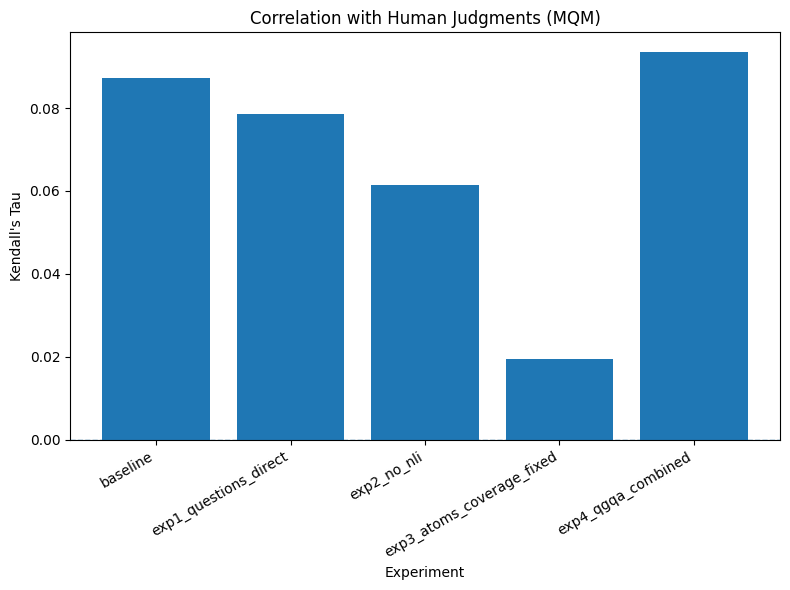

In [ ]:
plt.figure(figsize=(8, 6))

plt.bar(
    df_plot["run"],
    df_plot["tau_vs_mqm"]
)

plt.axhline(0, linestyle="--", linewidth=1)

plt.ylabel("Kendall's Tau")
plt.xlabel("Experiment")
# plt.grid(True)
plt.title("Correlation with Human Judgments (MQM)")

plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()


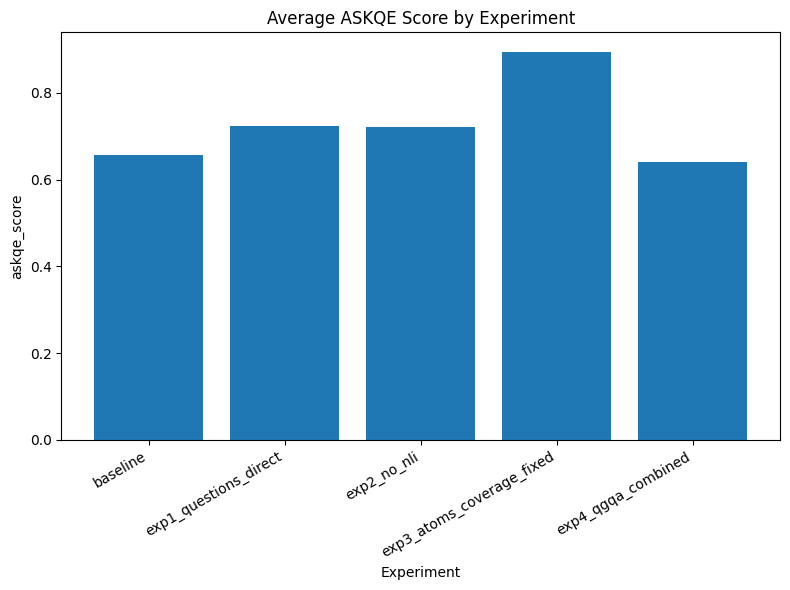

In [ ]:
plt.figure(figsize=(8, 6))

plt.bar(
    df_plot["run"],
    df_plot["mean_score"]
)

plt.ylabel("askqe_score")
plt.xlabel("Experiment")
# plt.grid(True)
plt.title("Average ASKQE Score by Experiment")

plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()